# LOCATION ANALYSIS ON YELP BUSINESS DATASETS

# Intializing Spark Session 

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Reading Yelp Business File

In [2]:
csv_options = {
    "header": True,
    "delimiter": ",",
    "quote": "\"",
    "escape": "\"",
    "multiLine": True,
    "inferSchema": True
}

# read the CSV file with the specified options
business = spark.read.format('csv').options(**csv_options).csv( "yelp_business.csv", header=True)
business.show()
print(f"Number of records {business.count()}")

+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|              null|"4855 E Warner Rd...|     Ahwatukee|   AZ|      85044|   33.3306902|  -111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|              null|"3101 Washington Rd"|      McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"Western

In [3]:
csv_options = {
    "header": True,
    "delimiter": ",",
    "quote": "\"",
    "escape": "\"",
    "multiLine": True,
    "inferSchema": True
}

# read the CSV file with the specified options
# df = spark.read.options(**csv_options).csv("path/to/csv/file")
business = spark.read.format('csv').options(**csv_options).csv( "yelp_business.csv")
business.show()
print(f"Number of records {business.count()}")

+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|              null|"4855 E Warner Rd...|     Ahwatukee|   AZ|      85044|   33.3306902|  -111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|              null|"3101 Washington Rd"|      McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"Western

- As the Address column contains comma, so used few parameters to read the business dataset properly into spark dataframe.

# Data Cleaning

In [4]:
from pyspark.sql.functions import col, sum

# Count the number of null values in each column
null_counts = business.select([sum(col(c).isNull().cast("int")).alias(c) for c in business.columns])

# Show the result
print("Null Values in Each Column")
null_counts.show()


Null Values in Each Column
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+
|business_id|name|neighborhood|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|categories|
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+
|          0|   0|      106552|      0|   1|    1|        623|       1|        1|    0|           0|      0|         0|
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+



### Removing irrelevant columns like neighbourhood, address, city, latitude, longitude

In [5]:
business = business.drop('neighborhood', 'address', 'city', 'latitude', 'longitude', 'postal_code')

In [6]:
business.show()

+--------------------+--------------------+-----+-----+------------+-------+--------------------+
|         business_id|                name|state|stars|review_count|is_open|          categories|
+--------------------+--------------------+-----+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|   AZ|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|   PA|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"Western Motor Ve...|   AZ|  1.5|          18|      1|Departments of Mo...|
|8DShNS-LuFqpEWIp0...|  "Sports Authority"|   AZ|  3.0|           9|      0|Sporting Goods;Sh...|
|PfOCPjBrlQAnz__NX...|"Brick House Tave...|   OH|  3.5|         116|      1|American (New);Ni...|
|o9eMRCWt5PkpLDE0g...|           "Messina"|   BW|  4.0|           5|      1| Italian;Restaurants|
|kCoE3jvEtg6UVz5SO...|        "BDJ Realty"|   NV|  4.0|           5|      1|Real Estate Servi...|
|OD2hnuuTJI9uotcKy..

In [7]:
print("After dropping irrelevant columns like neighbourhood, address, city, postal code, latitude, longitude")
null_counts.show()
print(f"Before pre-processing, number of records = {business.count()}")

After dropping irrelevant columns like neighbourhood, address, city, postal code, latitude, longitude
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+
|business_id|name|neighborhood|address|city|state|postal_code|latitude|longitude|stars|review_count|is_open|categories|
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+
|          0|   0|      106552|      0|   1|    1|        623|       1|        1|    0|           0|      0|         0|
+-----------+----+------------+-------+----+-----+-----------+--------+---------+-----+------------+-------+----------+

Before pre-processing, number of records = 174567


In [8]:
business = business.dropna()
null_counts = business.select([sum(col(c).isNull().cast("int")).alias(c) for c in business.columns])

print('Removing NULL rows:')
null_counts.show()
print(f"After pre-processing, number of records = {business.count()}")

Removing NULL rows:
+-----------+----+-----+-----+------------+-------+----------+
|business_id|name|state|stars|review_count|is_open|categories|
+-----------+----+-----+-----+------------+-------+----------+
|          0|   0|    0|    0|           0|      0|         0|
+-----------+----+-----+-----+------------+-------+----------+

After pre-processing, number of records = 174566


# Location Analysis

### Unique count of States 

In [9]:
from pyspark.sql.functions import col, concat, array

# Define the new value to append
unique_states = array()

# assuming 'df' is your DataFrame and 'col_name' is the column name of interest
unique_values = business.select(col('state')).distinct().collect()
count = 0
# print the unique values
for row in unique_values:
    count = count + 1
    print(row['state'])
print()
print(f"{count} states data is available in the dataset")

AZ
SC
SL
BW
MN
ZET
3
30
FAL
KHL
01
NYK
NTH
HLD
SCB
VA
QC
B
KY
ESX
NV
GLG
WI
CA
NE
MT
NC
BY
VT
6
DE
WLN
MLN
IL
XGL
C
WA
FLN
AL
IN
STG
FIF
OH
VS
PA
ELN
ABE
NY
TAM
PKN
ON
AB
EDH
CS
RCC
HU
GA
NI
NLK
CO
CMA
FL
AK
AR
WHT
CHE
ST

67 states data is available in the dataset


### Total number of businesses in each state

In [10]:
from pyspark.sql.functions import count
from pyspark.sql.functions import desc

city_counts = business.groupBy('state').agg(count('*').alias('count')).orderBy(desc('count'))
print('Total number of businesses in each state')
city_counts.show()

Total number of businesses in each state
+-----+-----+
|state|count|
+-----+-----+
|   AZ|52214|
|   NV|33086|
|   ON|30208|
|   NC|12956|
|   OH|12609|
|   PA|10109|
|   QC| 8169|
|   WI| 4754|
|  EDH| 3795|
|   BW| 3118|
|   IL| 1852|
|   SC|  679|
|  MLN|  208|
|  HLD|  179|
|  NYK|  152|
|  CHE|  143|
|  FIF|   85|
|  ELN|   47|
|  WLN|   38|
|    C|   28|
+-----+-----+
only showing top 20 rows



In [11]:
city_counts_df = city_counts.toPandas()

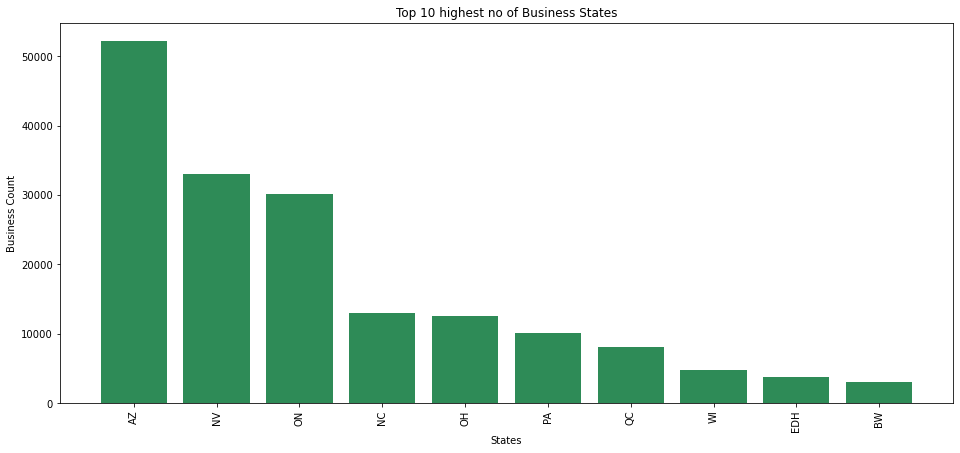

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.bar(city_counts_df.head(10)['state'], city_counts_df.head(10)['count'], color = "seagreen")
plt.xlabel("States")
plt.xticks(rotation = 90)
plt.ylabel("Business Count")
plt.title("Top 10 highest no of Business States")
plt.show()

### Count of Open and Closed Businesses in all States

In [13]:
is_open_counts = business.groupBy('is_open').agg(count('*').alias('count')).orderBy(desc('count'))
is_open_counts.show()

+-------+------+
|is_open| count|
+-------+------+
|      1|146701|
|      0| 27865|
+-------+------+



In [14]:
is_open_counts_df = is_open_counts.toPandas()

In [15]:
is_open_counts_df

,is_open,count
0,1,146701
1,0,27865


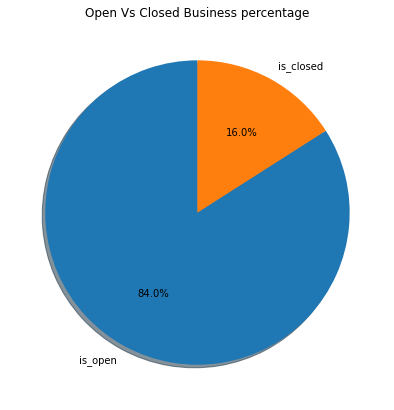

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,7))
plt.pie(is_open_counts_df['count'], labels=['is_open', 'is_closed'],shadow=True, startangle=90, autopct='%1.1f%%')
plt.title("Open Vs Closed Business percentage")
plt.show()

### Total count of businesses for open and closed business

In [17]:
from pyspark.sql.functions import count, expr

city_counts = business.groupBy('state').pivot('is_open', [0, 1]).agg(count('*'))
city_counts = city_counts.selectExpr("state", "`0` as closed", "`1` as open").orderBy(desc('closed'))
print('Data representing number of closed and open businesses')
city_counts.show()


Data representing number of closed and open businesses
+-----+------+-----+
|state|closed| open|
+-----+------+-----+
|   AZ|  8169|44045|
|   NV|  5595|27491|
|   ON|  5485|24723|
|   NC|  1857|11099|
|   OH|  1689|10920|
|   PA|  1446| 8663|
|   QC|  1244| 6925|
|   WI|   781| 3973|
|  EDH|   717| 3078|
|   BW|   372| 2746|
|   IL|   321| 1531|
|   SC|   107|  572|
|  MLN|    32|  176|
|  CHE|     9|  134|
|  HLD|     9|  170|
|  NYK|     7|  145|
|  ELN|     7|   40|
|  WLN|     4|   34|
|  FIF|     3|   82|
|   NI|     3|    7|
+-----+------+-----+
only showing top 20 rows



In [18]:
city_counts_partition = city_counts.toPandas()

In [19]:
city_counts_partition

,state,closed,open
0,AZ,8169.0,44045.0
1,NV,5595.0,27491.0
2,ON,5485.0,24723.0
3,NC,1857.0,11099.0
4,OH,1689.0,10920.0
...,...,...,...
62,FL,NaN,1.0
63,AK,NaN,1.0
64,AR,NaN,2.0
65,WHT,NaN,1.0


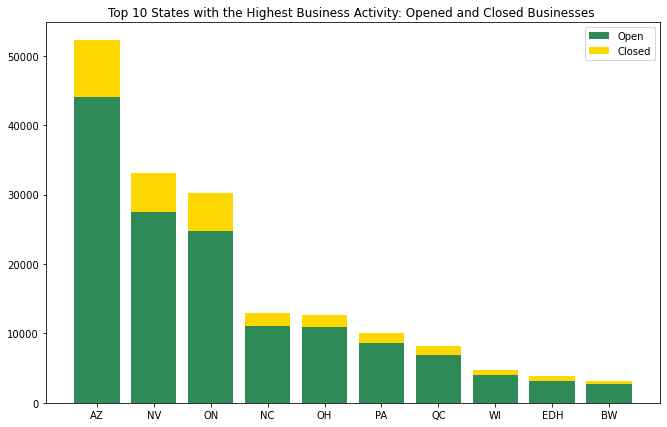

In [20]:
x = city_counts_partition['state'].head(10)
y2 = city_counts_partition['closed'].head(10)
y1 = city_counts_partition['open'].head(10)
 
# plot bars in stack manner
plt.figure(figsize=(11,7))
plt.bar(x, y1, color='seagreen')
plt.bar(x, y2, bottom=y1, color='gold')
plt.legend(["Open", "Closed"])
plt.title("Top 10 States with the Highest Business Activity: Opened and Closed Businesses ")
plt.show()


### Popular Business Categories 

In [21]:
from pyspark.sql.functions import split, explode, desc

words_df = business.select(explode(split(business['categories'], ';')).alias('category'))
word_counts = words_df.groupBy('category').count().orderBy(desc('count'))
word_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|54618|
|            Shopping|27971|
|                Food|24777|
|       Beauty & Spas|17014|
|       Home Services|16205|
|    Health & Medical|14230|
|           Nightlife|12154|
|      Local Services|11232|
|          Automotive|11051|
|                Bars|10563|
|Event Planning & ...| 9078|
|         Active Life| 8257|
|             Fashion| 7019|
|          Sandwiches| 6345|
|           Fast Food| 6280|
|         Hair Salons| 6140|
|American (Traditi...| 6097|
|               Pizza| 6067|
|        Coffee & Tea| 5936|
|     Hotels & Travel| 5736|
+--------------------+-----+
only showing top 20 rows



In [22]:
business_category = word_counts.toPandas()

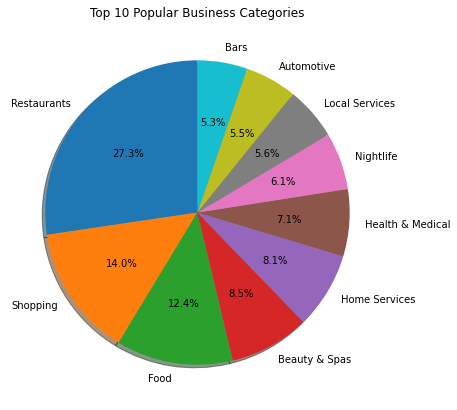

In [23]:

plt.figure(figsize=(16,7))
plt.pie(business_category['count'].head(10), labels=business_category['category'].head(10),shadow=True, startangle=90, autopct='%1.1f%%')
plt.title("Top 10 Popular Business Categories")
plt.show()

## Analysis on Business Categories for Open and Closed Business(1 & 5 Ratings)

In [24]:
business_df = business.toPandas()

In [25]:
business_df

,business_id,name,state,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",AZ,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",PA,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",AZ,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",AZ,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",OH,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...
174561,ALV5R8NkZ1KGOZeuZl3u0A,"""Whitby Toyota""",ON,4.0,4,1,Car Dealers;Automotive
174562,gRGalHVu6BcaUDIAGVW_xQ,"""Village Auto Body""",OH,5.0,3,1,Body Shops;Automotive
174563,XXvZBIHoJBU5d6-a-oyMWQ,"""AAM""",AZ,1.5,19,1,Home Services;Property Management;Real Estate
174564,lNpPGgM96nPIYM1shxciHg,"""Bronze Beauty Spray Tanning""",PA,5.0,14,1,Spray Tanning;Tanning;Beauty & Spas


### Analysis on 5 Rating Open Business Categories 

In [26]:
open_five_rating_df = business_df[(business_df["is_open"]==1) & (business_df['stars']==5.0)]
open_five_rating_df.head()

,business_id,name,state,stars,review_count,is_open,categories
8,EsMcGiZaQuG1OOvL9iUFug,"""Any Given Sundae""",PA,5.0,15,1,Coffee & Tea;Ice Cream & Frozen Yogurt;Food
9,TGWhGNusxyMaA4kQVBNeew,"""Detailing Gone Mobile""",NV,5.0,7,1,Automotive;Auto Detailing
11,Y0eMNa5C-YU1RQOZf9XvVA,"""CubeSmart Self Storage""",AZ,5.0,23,1,Local Services;Self Storage
18,0FMKDOU8TJT1x87OKYGDTg,"""Senior's Barber Shop""",AZ,5.0,65,1,Barbers;Beauty & Spas
30,nbhBRhZtdaZmMMeb2i02pg,"""Sunnyside Grill""",ON,5.0,3,1,Restaurants;Breakfast & Brunch


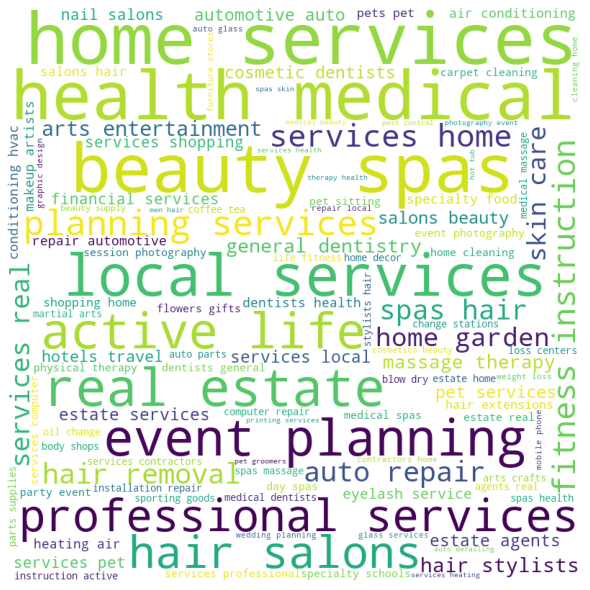

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

 
comment_words = ''
 
# iterate through the csv file
for val in open_five_rating_df.categories:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

For 5 Rating Open Business Categories, few most repeated categories are:
* Home Services
* Health Medical
* Beauty Spas
* Active Life
* Local Services

### Analysis on 1 Rating Open Business Categories 

In [28]:
open_one_rating_df = business_df[(business_df["is_open"]==1) & (business_df['stars'].isin([1.0,1.5]))]
open_one_rating_df.head()

,business_id,name,state,stars,review_count,is_open,categories
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",AZ,1.5,18,1,Departments of Motor Vehicles;Public Services ...
7,OD2hnuuTJI9uotcKycxg1A,"""Soccer Zone""",NV,1.5,9,1,Shopping;Sporting Goods
22,7YIy1tXOor9VCwvaSjuBHg,"""TSA Checkpoint T-4 A - Phoenix Sky Harbor Int...",AZ,1.5,46,1,Public Services & Government
45,rDMptJYWtnMhpQu_rRXHng,"""McDonald's""",AZ,1.0,10,1,Fast Food;Burgers;Restaurants
134,oZBISmgb-GjOdj-ik8UfjA,"""Cvs Pharmacy""",AZ,1.5,7,1,Shopping;Drugstores


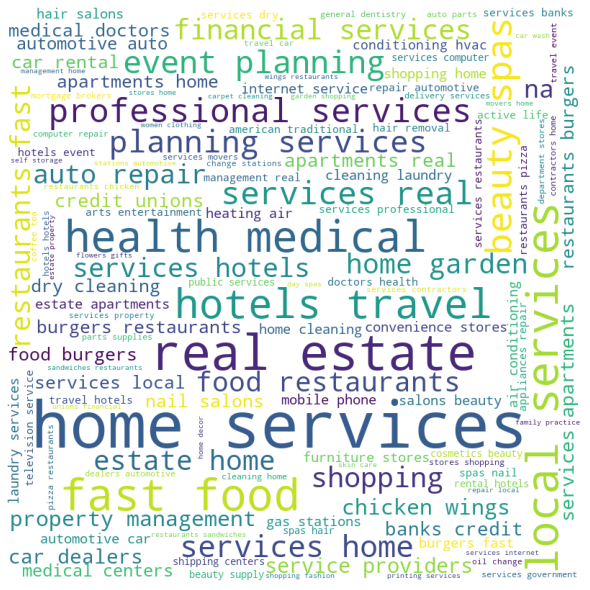

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

 
comment_words = ''
 
# iterate through the csv file
for val in open_one_rating_df.categories:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

For 1 Rating Open Business Categories, few most repeated categories are:
* Real Estate
* Home Services
* Health Medical
* Hotels travel
* Active Life
* Local Services
* Beauty Spas

### Analysis on 5 Rating Closed Business Categories 

In [30]:
closed_five_rating_df = business_df[(business_df["is_open"]==0) & (business_df['stars']==5.0)]
closed_five_rating_df.head()

,business_id,name,state,stars,review_count,is_open,categories
63,r6Jw8oRCeumxu7Y1WRxT7A,"""D&D Cleaning""",IL,5.0,4,0,Home Cleaning;Home Services;Window Washing
238,MfI-S7392ENwqWG89g4Opw,"""Southwest Drivetrain & 4WD""",AZ,5.0,4,0,Automotive;Auto Parts & Supplies
269,BWhspaDdGQwZAkXieytvUQ,"""Gina Louisa Designs""",NV,5.0,11,0,Flowers & Gifts;Shopping;Florists
464,h8m4WRcH4TgMFNFfAkfypg,"""Groovy""",PA,5.0,7,0,Antiques;Shopping;Toy Stores
486,dpQ1zg0cGBmlX7YFhdnT_g,"""Yoga Because""",AZ,5.0,3,0,Active Life;Yoga;Fitness & Instruction


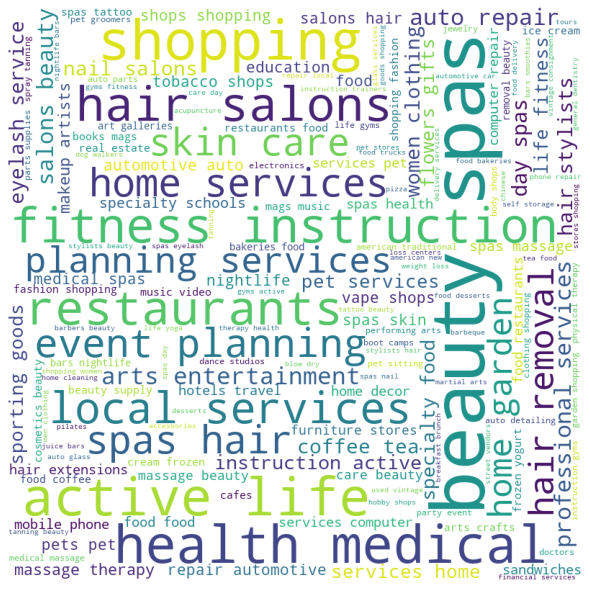

In [31]:
comment_words = ''
 
# iterate through the csv file
for val in closed_five_rating_df.categories:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

For 5 Rating Closed Business Categories, few most repeated categories are:
* Shopping
* Restaurants
* Fitness Instruction
* Hair Salons
* Health Medical
* Beauty Spas
* Active Life
* Local Services

### Analysis on 1 Rating Closed Business Categories 

In [32]:
closed_one_rating_df = business_df[(business_df["is_open"]==0) & (business_df['stars']==1.0)]
closed_one_rating_df.head()

,business_id,name,state,stars,review_count,is_open,categories
463,5rinwJ0Xs-Ay5GmAnzjO8Q,"""Levelz""",PA,1.0,3,0,Bars;Lounges;Nightlife
567,bVegY3CSU8Ogv0m2X_72bg,"""OrthoArizona The Foot and Ankle Center""",AZ,1.0,7,0,Doctors;Health & Medical;Orthopedists
1398,xi8D-CjJlH7ge1CgMfkdTg,"""Residences of South Hills - Greystar""",PA,1.0,4,0,Apartments;Home Services;Real Estate
1483,vYeVKt2S1zMTMSkVQgTsAA,"""My Affordable Handyman""",NV,1.0,4,0,Handyman;Boat Repair;Professional Services;Hom...
1548,PAXUkXtz3YbzNZYlSTuMhA,"""Hudec Dental Associates""",OH,1.0,3,0,Health & Medical;Dentists


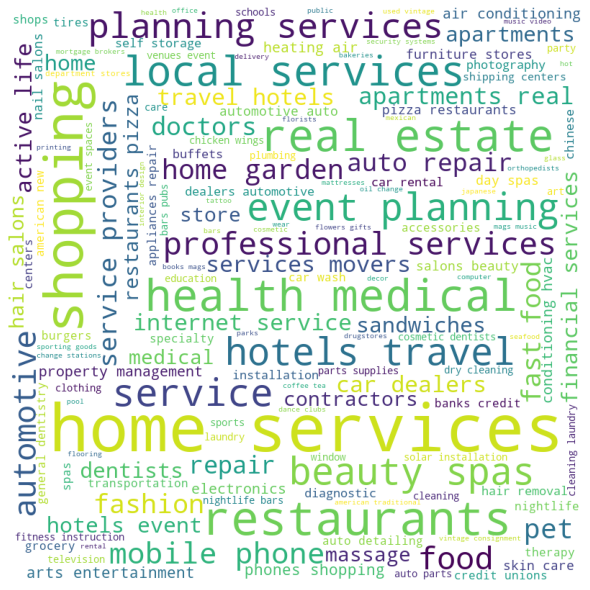

In [33]:
comment_words = ''
 
# iterate through the csv file
for val in closed_one_rating_df.categories:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

For 1 Rating Closed Business Categories, few most repeated categories are:
* Home Services
* Hotels Travel
* Health Medical
* Shopping
* Event Planning
* Beauty Spas
* Restaurants
* Planning Services

## Average Rating for Open and Closed Business

In [34]:
business_filt_open = business.filter(business.is_open == 1)
business_filt_close = business.filter(business.is_open == 0)

### Rating for open business

In [35]:
# Average rating
from pyspark.sql.functions import avg
avg_star_rating_by_state_open = business_filt_open.groupBy('state').agg(avg('stars'))
avg_star_rating_by_state_open.show()

+-----+------------------+
|state|        avg(stars)|
+-----+------------------+
|   AZ|3.7626064252469065|
|   SC| 3.679195804195804|
|   SL|               5.0|
|   BW|3.8124544792425348|
|   MN|               3.5|
|  ZET|               3.5|
|    3|               5.0|
|   30|               3.0|
|  FAL|               4.0|
|  KHL|               3.5|
|   01|               3.7|
|  NYK| 3.696551724137931|
|  NTH|               3.5|
|  HLD|3.6323529411764706|
|  SCB|               4.1|
|   VA|               4.0|
|   QC|  3.68057761732852|
|    B|               2.5|
|   KY|               4.5|
|  ESX| 4.136363636363637|
+-----+------------------+
only showing top 20 rows



In [36]:
#Descending order
from pyspark.sql.functions import avg, round, countDistinct
avg_star_rating_by_state_asc_open = business_filt_open.groupBy('state').agg(avg('stars')).orderBy('avg(stars)', ascending=False)
avg_star_rating_by_state_asc_open.show()

+-----+-----------------+
|state|       avg(stars)|
+-----+-----------------+
|   GA|              5.0|
|   SL|              5.0|
|   AL|              5.0|
|   AB|              5.0|
|    3|              5.0|
|  RCC|              5.0|
|   KY|              4.5|
|   HU|              4.5|
|   CS|              4.5|
|  STG|              4.5|
|  FLN|             4.25|
|   VT|             4.25|
|  ESX|4.136363636363637|
|   ST|4.136363636363637|
|   CA|            4.125|
|  SCB|              4.1|
|  GLG|              4.0|
|   VA|              4.0|
|   NE|              4.0|
|   DE|              4.0|
+-----+-----------------+
only showing top 20 rows



In [37]:
avg_star_rating_by_state_asc_open.printSchema()

root
 |-- state: string (nullable = true)
 |-- avg(stars): double (nullable = true)



In [38]:
avg_star_rating_by_state_asc_open = avg_star_rating_by_state_asc_open.withColumn('avg(stars)', round('avg(stars)', 0))
avg_star_rating_by_state_asc_open.show()

+-----+----------+
|state|avg(stars)|
+-----+----------+
|   GA|       5.0|
|   SL|       5.0|
|   AL|       5.0|
|   AB|       5.0|
|    3|       5.0|
|  RCC|       5.0|
|   KY|       5.0|
|   HU|       5.0|
|   CS|       5.0|
|  STG|       5.0|
|  FLN|       4.0|
|   VT|       4.0|
|  ESX|       4.0|
|   ST|       4.0|
|   CA|       4.0|
|  SCB|       4.0|
|  GLG|       4.0|
|   VA|       4.0|
|   NE|       4.0|
|   DE|       4.0|
+-----+----------+
only showing top 20 rows



In [39]:
avg_star_rating_by_state_asc_count_open = avg_star_rating_by_state_asc_open.groupBy('avg(stars)').agg(countDistinct('state').alias('state_count'))
avg_star_rating_by_state_asc_count_open = avg_star_rating_by_state_asc_count_open.orderBy('avg(stars)', ascending=False)
avg_star_rating_by_state_asc_count_open.show()

+----------+-----------+
|avg(stars)|state_count|
+----------+-----------+
|       5.0|         10|
|       4.0|         43|
|       3.0|         11|
|       2.0|          1|
+----------+-----------+



In [40]:
avg_star_rating_by_state_open = avg_star_rating_by_state_asc_count_open.toPandas()

In [41]:
avg_star_rating_by_state_open

,avg(stars),state_count
0,5.0,10
1,4.0,43
2,3.0,11
3,2.0,1


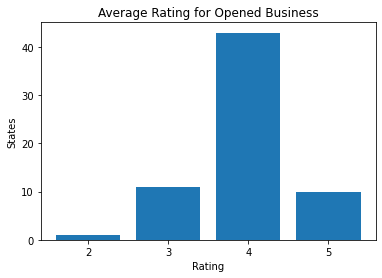

In [42]:
plt.bar(avg_star_rating_by_state_open['avg(stars)'],avg_star_rating_by_state_open['state_count'])
plt.xlabel("Rating")
plt.xticks(np.arange(2, 6, 1))
plt.ylabel("States")
plt.title("Average Rating for Opened Business")
plt.show()

* •	In businesses that are currently operating, the number of states who was given a rating of 4 is the highest at 43, followed by a rating of 3 which is the second highest at 11. Ratings of 5 and 2 come next, and there is no data related to rating of 1, which means all customers rated more than or equal to 1.5.

### Rating for closed business

In [43]:
# Average rating
from pyspark.sql.functions import avg
avg_star_rating_by_state_close = business_filt_close.groupBy('state').agg(avg('stars'))
avg_star_rating_by_state_close.show()

+-----+------------------+
|state|        avg(stars)|
+-----+------------------+
|   AZ|3.5460276655649405|
|   SC|3.4205607476635516|
|   BW|3.7594086021505375|
|  NYK|               3.5|
|  HLD|3.5555555555555554|
|   QC|3.5538585209003215|
|  ESX|               3.5|
|   NV|3.6117068811438786|
|   WI| 3.480153649167734|
|   CA|               5.0|
|   MT|               3.0|
|   NC|3.4698438341410878|
|   BY|               5.0|
|  WLN|               4.0|
|  MLN|          3.828125|
|   IL| 3.425233644859813|
|    C|               3.5|
|   WA|               4.0|
|   IN|              3.75|
|  FIF|               2.5|
+-----+------------------+
only showing top 20 rows



In [44]:
#Descending order
from pyspark.sql.functions import avg, round, countDistinct
avg_star_rating_by_state_asc_close = business_filt_close.groupBy('state').agg(avg('stars')).orderBy('avg(stars)', ascending=False)
avg_star_rating_by_state_asc_close.show()

+-----+------------------+
|state|        avg(stars)|
+-----+------------------+
|   CA|               5.0|
|   BY|               5.0|
|  WLN|               4.0|
|   WA|               4.0|
|  ELN| 3.857142857142857|
|  MLN|          3.828125|
|   BW|3.7594086021505375|
|   IN|              3.75|
|  EDH|3.7433751743375177|
|  CHE|3.7222222222222223|
|   NV|3.6117068811438786|
|  HLD|3.5555555555555554|
|   QC|3.5538585209003215|
|   AZ|3.5460276655649405|
|   PA|3.5235131396957122|
|    C|               3.5|
|  NYK|               3.5|
|   NI|               3.5|
|  ESX|               3.5|
|   WI| 3.480153649167734|
+-----+------------------+
only showing top 20 rows



In [45]:
avg_star_rating_by_state_asc_close.printSchema()

root
 |-- state: string (nullable = true)
 |-- avg(stars): double (nullable = true)



In [46]:
avg_star_rating_by_state_asc_close = avg_star_rating_by_state_asc_close.withColumn('avg(stars)', round('avg(stars)', 0))
avg_star_rating_by_state_asc_close.show()

+-----+----------+
|state|avg(stars)|
+-----+----------+
|   CA|       5.0|
|   BY|       5.0|
|  WLN|       4.0|
|   WA|       4.0|
|  ELN|       4.0|
|  MLN|       4.0|
|   BW|       4.0|
|   IN|       4.0|
|  EDH|       4.0|
|  CHE|       4.0|
|   NV|       4.0|
|  HLD|       4.0|
|   QC|       4.0|
|   AZ|       4.0|
|   PA|       4.0|
|    C|       4.0|
|  NYK|       4.0|
|   NI|       4.0|
|  ESX|       4.0|
|   WI|       3.0|
+-----+----------+
only showing top 20 rows



In [47]:
avg_star_rating_by_state_asc_count_close = avg_star_rating_by_state_asc_close.groupBy('avg(stars)').agg(countDistinct('state').alias('state_count'))
avg_star_rating_by_state_asc_count_close = avg_star_rating_by_state_asc_count_close.orderBy('avg(stars)', ascending=False)
avg_star_rating_by_state_asc_count_close.show()

+----------+-----------+
|avg(stars)|state_count|
+----------+-----------+
|       5.0|          2|
|       4.0|         17|
|       3.0|          8|
+----------+-----------+



In [48]:
avg_star_rating_by_state_close = avg_star_rating_by_state_asc_count_close.toPandas()

In [49]:
avg_star_rating_by_state_close

,avg(stars),state_count
0,5.0,2
1,4.0,17
2,3.0,8


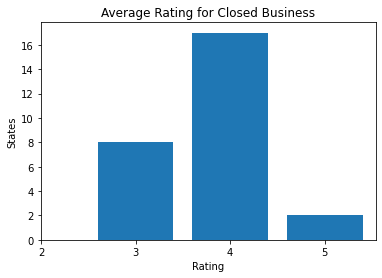

In [50]:
import numpy as np

plt.bar(avg_star_rating_by_state_close['avg(stars)'],avg_star_rating_by_state_close['state_count'])
plt.xlabel("Rating")
plt.xticks(np.arange(2, 6, 1))
plt.ylabel("States")
plt.title("Average Rating for Closed Business")
plt.show()

* In businesses that are currently closed, the number of states who was given a rating of 4 is the highest at 17, followed by a rating of 3 which is the second highest at 18. Ratings of 5 is at the least, and there is no data related to rating of 1 and 2, which means all customers rated more than or equal to 2.5.

### Popular business in count and rating w.r.t states

In [51]:
business_df

,business_id,name,state,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",AZ,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",PA,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",AZ,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",AZ,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",OH,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...
...,...,...,...,...,...,...,...
174561,ALV5R8NkZ1KGOZeuZl3u0A,"""Whitby Toyota""",ON,4.0,4,1,Car Dealers;Automotive
174562,gRGalHVu6BcaUDIAGVW_xQ,"""Village Auto Body""",OH,5.0,3,1,Body Shops;Automotive
174563,XXvZBIHoJBU5d6-a-oyMWQ,"""AAM""",AZ,1.5,19,1,Home Services;Property Management;Real Estate
174564,lNpPGgM96nPIYM1shxciHg,"""Bronze Beauty Spray Tanning""",PA,5.0,14,1,Spray Tanning;Tanning;Beauty & Spas


In [52]:
from pyspark.sql.functions import avg
categories = business.select('state', 'stars', explode(split(business['categories'], ';')).alias('category'))

popular = categories.groupBy('state', 'category').agg(count('*').alias('count'), avg('stars').alias('avg_stars'))
popular.show()

+-----+--------------------+-----+------------------+
|state|            category|count|         avg_stars|
+-----+--------------------+-----+------------------+
|   NV|Real Estate Services|  460|3.9478260869565216|
|   ON|Photography Store...|   79| 3.550632911392405|
|   NV| Diagnostic Services|  117|3.3333333333333335|
|   IL|             Fashion|   81| 3.376543209876543|
|  EDH|     Hotels & Travel|  242|3.6942148760330578|
|   AZ|Junk Removal & Ha...|   83| 4.259036144578313|
|   NC|Windows Installation|   24|3.5208333333333335|
|  FIF|          Automotive|    2|               3.0|
|   AZ|             Parking|   50|              3.43|
|   AZ|   Plus Size Fashion|   64|          3.828125|
|   AZ|Shared Office Spaces|   19|4.2368421052631575|
|   IL|           Aquariums|    1|               4.0|
|   NY|              Donuts|    1|               1.0|
|   QC|    Eyebrow Services|    2|               4.0|
|   NV|        Jazz & Blues|   13|3.8846153846153846|
|   AZ|    Vacation Rentals|

In [53]:
popular_state_business_category_df = popular.toPandas()

In [54]:
popular_state_business_category_df

,state,category,count,avg_stars
0,NV,Real Estate Services,460,3.947826
1,ON,Photography Stores & Services,79,3.550633
2,NV,Diagnostic Services,117,3.333333
3,IL,Fashion,81,3.376543
4,EDH,Hotels & Travel,242,3.694215
...,...,...,...,...
10431,IL,Office Cleaning,3,4.333333
10432,OH,Bike tours,1,5.000000
10433,OH,Party Characters,1,5.000000
10434,WLN,Gastropubs,1,3.500000


In [55]:
popular_state_business_category_top_10_df = popular_state_business_category_df.sort_values(by = ['count','avg_stars'], ascending=False).head(20)

In [56]:
popular_state_business_category_top_10_df

,state,category,count,avg_stars
2343,ON,Restaurants,13501,3.378935
9839,AZ,Restaurants,10598,3.413286
6872,AZ,Shopping,8788,3.730086
9994,AZ,Home Services,7892,3.756019
9100,NV,Restaurants,7135,3.443798
5926,AZ,Health & Medical,6565,3.883778
3043,ON,Food,5931,3.547462
2397,AZ,Beauty & Spas,5776,4.110111
341,NV,Shopping,5490,3.743078
1753,AZ,Food,5226,3.675277


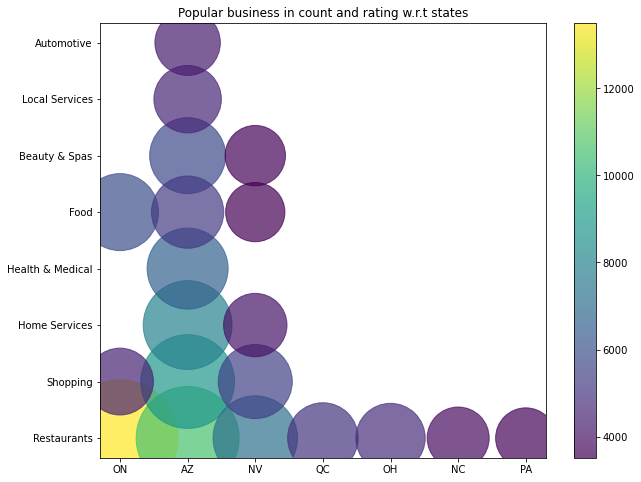

In [57]:
plt.figure(figsize=(10,8))
plt.scatter(popular_state_business_category_top_10_df['state'],popular_state_business_category_top_10_df['category'],s= popular_state_business_category_top_10_df['count'],c=popular_state_business_category_top_10_df['count'],alpha=0.7)
plt.colorbar()
plt.title("Popular business in count and rating w.r.t states")
plt.show()

# Data Modelling

In [58]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression

In [59]:
split_col = split(business['categories'], ';')

In [60]:
business = business.withColumn('primary_category', split_col)
print("The dataset after splitting the categories column")
business.show()

The dataset after splitting the categories column
+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+
|         business_id|                name|state|stars|review_count|is_open|          categories|    primary_category|
+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|   AZ|  4.0|          22|      1|Dentists;General ...|[Dentists, Genera...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|   PA|  3.0|          11|      1|Hair Stylists;Hai...|[Hair Stylists, H...|
|KQPW8lFf1y5BT2Mxi...|"Western Motor Ve...|   AZ|  1.5|          18|      1|Departments of Mo...|[Departments of M...|
|8DShNS-LuFqpEWIp0...|  "Sports Authority"|   AZ|  3.0|           9|      0|Sporting Goods;Sh...|[Sporting Goods, ...|
|PfOCPjBrlQAnz__NX...|"Brick House Tave...|   OH|  3.5|         116|      1|American (New);Ni...|[American (New), ...

In [61]:
from pyspark.sql.functions import when

business = business.withColumn("Perfomance", when(business["stars"] >= 3, "Good").otherwise("Poor"))
print("The business dataset after classifying the rating column")
business.show()

The business dataset after classifying the rating column
+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+----------+
|         business_id|                name|state|stars|review_count|is_open|          categories|    primary_category|Perfomance|
+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+----------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|   AZ|  4.0|          22|      1|Dentists;General ...|[Dentists, Genera...|      Good|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|   PA|  3.0|          11|      1|Hair Stylists;Hai...|[Hair Stylists, H...|      Good|
|KQPW8lFf1y5BT2Mxi...|"Western Motor Ve...|   AZ|  1.5|          18|      1|Departments of Mo...|[Departments of M...|      Poor|
|8DShNS-LuFqpEWIp0...|  "Sports Authority"|   AZ|  3.0|           9|      0|Sporting Goods;Sh...|[Sporting Goods, ...|      Good|
|PfOCPjBrlQAnz__NX...|"Brick Hous

In [62]:
df = business.select([col(c).alias(c) for c in business.columns])
df.show()
df_ml = df.select("state", "primary_category", "Perfomance")
print("Machine Learning: Selecting the required columns in the dataset:")
df_ml.show()

+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+----------+
|         business_id|                name|state|stars|review_count|is_open|          categories|    primary_category|Perfomance|
+--------------------+--------------------+-----+-----+------------+-------+--------------------+--------------------+----------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|   AZ|  4.0|          22|      1|Dentists;General ...|[Dentists, Genera...|      Good|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|   PA|  3.0|          11|      1|Hair Stylists;Hai...|[Hair Stylists, H...|      Good|
|KQPW8lFf1y5BT2Mxi...|"Western Motor Ve...|   AZ|  1.5|          18|      1|Departments of Mo...|[Departments of M...|      Poor|
|8DShNS-LuFqpEWIp0...|  "Sports Authority"|   AZ|  3.0|           9|      0|Sporting Goods;Sh...|[Sporting Goods, ...|      Good|
|PfOCPjBrlQAnz__NX...|"Brick House Tave...|   OH|  3.5|         116|      1|American (New)

In [63]:
string_indexer = StringIndexer(inputCol="state", outputCol="state_index")
encoder = OneHotEncoder(inputCols=["state_index"], outputCols=["state_vector"])
pipeline1 = Pipeline(stages=[string_indexer, encoder])
transformed_df = pipeline1.fit(df_ml).transform(df_ml)

transformed_df.show()

+-----+--------------------+----------+-----------+--------------+
|state|    primary_category|Perfomance|state_index|  state_vector|
+-----+--------------------+----------+-----------+--------------+
|   AZ|[Dentists, Genera...|      Good|        0.0|(66,[0],[1.0])|
|   PA|[Hair Stylists, H...|      Good|        5.0|(66,[5],[1.0])|
|   AZ|[Departments of M...|      Poor|        0.0|(66,[0],[1.0])|
|   AZ|[Sporting Goods, ...|      Good|        0.0|(66,[0],[1.0])|
|   OH|[American (New), ...|      Good|        4.0|(66,[4],[1.0])|
|   BW|[Italian, Restaur...|      Good|        9.0|(66,[9],[1.0])|
|   NV|[Real Estate Serv...|      Good|        1.0|(66,[1],[1.0])|
|   NV|[Shopping, Sporti...|      Poor|        1.0|(66,[1],[1.0])|
|   PA|[Coffee & Tea, Ic...|      Good|        5.0|(66,[5],[1.0])|
|   NV|[Automotive, Auto...|      Good|        1.0|(66,[1],[1.0])|
|   PA|[Breakfast & Brun...|      Good|        5.0|(66,[5],[1.0])|
|   AZ|[Local Services, ...|      Good|        0.0|(66,[0],[1.

In [64]:
hashingTF = HashingTF(inputCol="primary_category", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
pipeline2 = Pipeline(stages=[hashingTF, idf])
transformed_df = pipeline2.fit(transformed_df).transform(transformed_df)
print("Dataset after preprocessing")
transformed_df.show()

Dataset after preprocessing
+-----+--------------------+----------+-----------+--------------+--------------------+--------------------+
|state|    primary_category|Perfomance|state_index|  state_vector|        raw_features|            features|
+-----+--------------------+----------+-----------+--------------+--------------------+--------------------+
|   AZ|[Dentists, Genera...|      Good|        0.0|(66,[0],[1.0])|(262144,[14296,58...|(262144,[14296,58...|
|   PA|[Hair Stylists, H...|      Good|        5.0|(66,[5],[1.0])|(262144,[44383,64...|(262144,[44383,64...|
|   AZ|[Departments of M...|      Poor|        0.0|(66,[0],[1.0])|(262144,[87598,20...|(262144,[87598,20...|
|   AZ|[Sporting Goods, ...|      Good|        0.0|(66,[0],[1.0])|(262144,[7613,397...|(262144,[7613,397...|
|   OH|[American (New), ...|      Good|        4.0|(66,[4],[1.0])|(262144,[24115,26...|(262144,[24115,26...|
|   BW|[Italian, Restaur...|      Good|        9.0|(66,[9],[1.0])|(262144,[184,2688...|(262144,[184,

In [65]:
indexer = StringIndexer(inputCol="Perfomance", outputCol="label")
transformed_df = indexer.fit(transformed_df).transform(transformed_df)

In [66]:
assembler = VectorAssembler(inputCols=["state_vector", "features"], outputCol="features_vec")
transformed_df = assembler.transform(transformed_df)

In [67]:
(training_data, test_data) = transformed_df.randomSplit([0.7, 0.3], seed=42)

In [68]:
lr = LogisticRegression(featuresCol="features_vec", labelCol="label", maxIter=10)
print("Training the Logistic Regression model:")
lr_model = lr.fit(training_data)

Training the Logistic Regression model:


In [69]:
# Make predictions on the testing data
predictions = lr_model.transform(test_data)

In [70]:
# Evaluate the model's performance
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8179512120691957


• The accuracy of the fitted Logistic Regression model was calculated to be 81.79% on 
the testing data. This means that the model was able to correctly predict the labels for 
approximately 81.79% of the samples in the testing data.

• The model is reasonably accurate in predicting the performance of businesses based 
on their state and primary category.

# Conclusion

In this project, we have performed location analysis on Yelp business datasets using Spark, and we used logistic regression to identify which combination of states and categories could be potentially good for a business setup. The results of this analysis can help businesses make data-driven decisions to optimize their operations and improve customer satisfaction. This can aid entrepreneur in choosing the right location for their businesses to prosper and can also help them to determine which business category could be successful in that particular location. 